In [59]:
"""
this notebook is referenced from:
https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/05-transformers-and-MH-attention.html
https://github.com/aceliuchanghong/LLMs-from-scratch
https://github.com/aceliuchanghong/llms-from-scratch-cn
https://github.com/aceliuchanghong/Transformer-from-scratch
"""

'\nthis notebook is referenced from:\nhttps://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/05-transformers-and-MH-attention.html\nhttps://github.com/aceliuchanghong/LLMs-from-scratch\nhttps://github.com/aceliuchanghong/llms-from-scratch-cn\nhttps://github.com/aceliuchanghong/Transformer-from-scratch\n'

In [60]:
# 引入依赖
# PyTorch Lightning
# import lightning as L

# Standard libraries
import math
import os
import sys
from functools import partial

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100
from tqdm.notebook import tqdm

# Log
from dotenv import load_dotenv
import logging
from termcolor import colored

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib_inline.backend_inline
import numpy as np
import pandas as pd

load_dotenv()
log_level = os.getenv("LOG_LEVEL", "INFO").upper()
logging.basicConfig(
    level=getattr(logging, log_level),
    format="%(asctime)s-%(levelname)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger(__name__)

In [61]:
# 超参数设置一下
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 4 # 批次大小
context_length = 16 # 文本长度 ==> 截取一段话,其最多有 context_length 个 token 
d_model = 64  # 模型维度
num_blocks = 8  # 模型 block 层数
num_heads = 4  # 通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 学习率 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # 迭代次数
eval_interval = 50  # 每多少轮验证模型 
eval_iters = 20  # 评估模型时，需要对损失进行多少次迭代平均

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [62]:
# 文件读取
with open('../../../z_using_files/txt/Reverend_Insanity.txt','r',encoding='utf-8') as f:
    text = f.read()
text[:200]

'Information\nTable of Contents URL: https://novelfull.com/reverend-insanity.html\n\n\n\nAuthor:Gu Zhen Ren, 蛊真人\nAlternative names:Cổ chân nhân, Daoist Gu, Gu Zhen Ren, 蛊真人\nGenre:Fantasy, Martial Arts, Acti'

# 1.文本token化==>Tokenization

In [63]:

# 使用 TikToken 将文本 token 化
import tiktoken
cl100k_base = tiktoken.get_encoding("cl100k_base")
enc = cl100k_base.encode(text)
tokenized_text = torch.tensor(enc, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item()
logger.info(colored(f"{len(enc)}", "green"))
logger.info(colored(f"{enc[:20]}", "green"))
logger.info(colored(f"max_token_value:{max_token_value}", "green"))

2025-01-12 10:05:49-INFO: 6581059
2025-01-12 10:05:49-INFO: [15218, 198, 2620, 315, 36962, 5665, 25, 3788, 1129, 39142, 491, 620, 916, 10991, 424, 408, 22610, 39370, 2628, 1038]
2025-01-12 10:05:49-INFO: max_token_value:100252


2025-01-12 10:05:49-INFO: 5922953, 658106


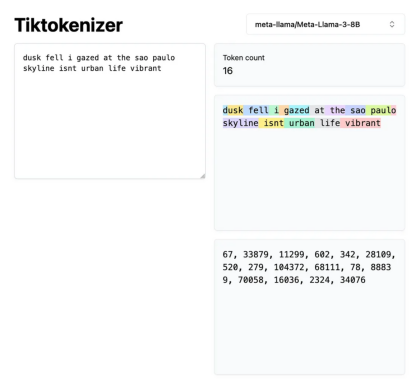

In [64]:
# 数据分割训练集,验证集
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]
train_data, val_data , len(train_data), len(val_data)
logger.info(colored(f"{len(train_data)}, {len(val_data)}", "green"))

# 进程==>Tokenization结束
img_path= '../../../z_using_files/img/article/token.png'
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')  # 不显示坐标轴
plt.show()

# 2.向量嵌入

In [65]:
data = train_data
# 从数据集中随机选择起始位置[0,len(data) - context_length)，以便之后从中提取长度为 context_length 的序列
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
logger.info(colored(f"idxs:{idxs}", "green"))
x_batch = torch.stack([data[idx : idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1 : idx + context_length + 1] for idx in idxs])
logger.info(colored(f"{x_batch.shape},{y_batch.shape}", "green"))

2025-01-12 10:05:49-INFO: idxs:tensor([  29385, 2744535,  404737,  924702])
2025-01-12 10:05:49-INFO: torch.Size([4, 16]),torch.Size([4, 16])


In [66]:
# 准备嵌入,1.先创建一个嵌入查找表,2.然后将输入序列 x_batch,y_batch 映射到嵌入空间

# 在 PyTorch 中，索引是从 0 开始计数的。如果 max_token_value = 100，那么 token 的取值范围是 [0, 100]，共 101 个值
# nn.Embedding 的 num_embeddings 参数 ==> 支持的索引范围是 [0, num_embeddings - 1]
input_embedding_lookup_table = nn.Embedding(max_token_value + 1, d_model)
logger.info(colored(f"{input_embedding_lookup_table.weight.data.shape}", "green"))

2025-01-12 10:05:49-INFO: torch.Size([100253, 64])


2025-01-12 10:05:49-INFO: torch.Size([4, 16, 64]),torch.Size([4, 16, 64])


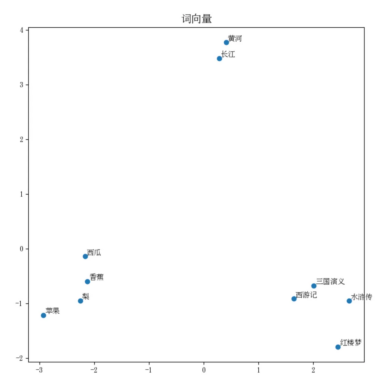

In [67]:
# 将输入序列 x_batch,y_batch 映射到嵌入空间
x_batch_embedded = input_embedding_lookup_table(x_batch)
y_batch_embedded = input_embedding_lookup_table(y_batch)
logger.info(colored(f"{x_batch_embedded.shape},{y_batch_embedded.shape}", "green"))

# 进程==>向量化结束
img2_path= '../../../z_using_files/img/article/vector.png'
img2 = mpimg.imread(img2_path)
plt.imshow(img2)
plt.axis('off')
plt.show()

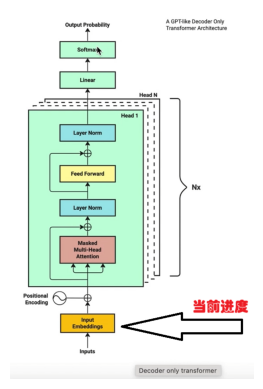

In [68]:
img3_path= '../../../z_using_files/img/article/decoder2.png'
img3 = mpimg.imread(img3_path)
plt.imshow(img3)
plt.axis('off')
plt.show()

# 3.位置信息编码
位置编码的作用是为每个位置生成一个唯一的向量，以便模型能够区分序列中不同位置的词。

In [69]:
import math
position_encoding_lookup_table = torch.zeros(context_length, d_model)
logger.info(colored(f"全0矩阵形状:{position_encoding_lookup_table.shape}", "green"))

2025-01-12 10:05:49-INFO: 全0矩阵形状:torch.Size([16, 64])


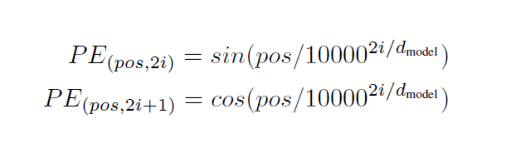

In [70]:
img4_path= '../../../z_using_files/img/article/attention_5.png'
img4 = mpimg.imread(img4_path)
plt.imshow(img4)
plt.axis('off')
plt.show()

In [71]:
# position 张量表示序列中每个位置的索引
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
position, position.shape

(tensor([[ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 7.],
         [ 8.],
         [ 9.],
         [10.],
         [11.],
         [12.],
         [13.],
         [14.],
         [15.]]),
 torch.Size([16, 1]))

In [72]:
# position 会与一个频率因子（如正弦和余弦函数）结合，生成位置编码矩阵
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table, position_encoding_lookup_table.shape

(tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
           1.3335e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
           2.6670e-04,  1.0000e+00],
         ...,
         [ 4.2017e-01,  9.0745e-01, -3.1822e-01,  ...,  1.0000e+00,
           1.7336e-03,  1.0000e+00],
         [ 9.9061e-01,  1.3674e-01, -8.7899e-01,  ...,  1.0000e+00,
           1.8669e-03,  1.0000e+00],
         [ 6.5029e-01, -7.5969e-01, -9.6821e-01,  ...,  1.0000e+00,
           2.0003e-03,  1.0000e+00]]),
 torch.Size([16, 64]))

In [73]:
# position_encoding_lookup_table 添加 batch_size 维度
# unsqueeze(0) 在第 0 维度（最外层）增加一个维度 
# .expand(batch_size, -1, -1): 将第 0 维度扩展到 batch_size 个样本, -1 表示保持该维度的大小不变 
# 即 保持 context_length 和 d_model 维度的大小不变。
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1)
position_encoding_lookup_table, position_encoding_lookup_table.shape

(tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
            0.0000e+00,  1.0000e+00],
          [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
            1.3335e-04,  1.0000e+00],
          [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
            2.6670e-04,  1.0000e+00],
          ...,
          [ 4.2017e-01,  9.0745e-01, -3.1822e-01,  ...,  1.0000e+00,
            1.7336e-03,  1.0000e+00],
          [ 9.9061e-01,  1.3674e-01, -8.7899e-01,  ...,  1.0000e+00,
            1.8669e-03,  1.0000e+00],
          [ 6.5029e-01, -7.5969e-01, -9.6821e-01,  ...,  1.0000e+00,
            2.0003e-03,  1.0000e+00]],
 
         [[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
            0.0000e+00,  1.0000e+00],
          [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
            1.3335e-04,  1.0000e+00],
          [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
            2.6670e-04,  1.0000e+00],
          ...,
    

In [74]:
# 将位置编码矩阵与输入序列的嵌入相加
x_batch = x_batch_embedded + position_encoding_lookup_table
y_batch = y_batch_embedded + position_encoding_lookup_table
logger.info(colored(f"{x_batch.shape},{y_batch.shape}", "green"))
pd.DataFrame(x_batch[0].cpu().detach().numpy())

2025-01-12 10:05:49-INFO: torch.Size([4, 16, 64]),torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,2.162359,0.014595,0.796178,3.356206,-0.160013,2.460964,-1.190869,2.463076,0.365047,3.568545,...,-0.497161,2.278974,-0.641930,0.104591,1.779520,2.250866,0.372928,0.293298,0.360525,1.593397
1,-1.441724,1.032295,-1.263621,1.545862,1.598404,-1.741174,0.945541,0.514185,-0.469206,1.146546,...,-0.177246,0.235538,0.100418,1.436226,-0.868371,-0.396999,1.192728,0.310037,-0.226474,0.037397
2,0.934298,-0.325756,0.423654,1.157883,-0.440400,1.219224,1.466880,-0.394185,0.819145,0.461198,...,-1.374711,0.659871,0.992754,0.314204,0.857463,0.791672,-0.002372,0.952962,-0.185898,1.141504
3,-0.534895,-0.920663,-0.037929,-0.961752,1.199708,0.455698,1.498381,-0.288265,0.193662,1.164371,...,0.406057,-0.499149,-0.364658,1.453952,-0.274258,-0.924834,2.173931,2.523131,1.921539,1.818131
4,-0.691732,0.343826,-0.289331,0.027617,2.276036,-0.776878,1.074125,-1.145550,-0.284868,0.010862,...,-2.552323,0.331733,0.770866,0.903168,-1.648390,1.315307,0.863274,0.719231,-0.283830,-0.692501
5,0.502267,0.106578,0.562975,-1.137285,1.419405,0.204962,1.496488,-0.035228,2.882603,1.633610,...,-0.863099,0.288578,1.829265,0.625285,1.089936,1.971268,-1.609619,-1.361162,0.867678,1.793636
6,0.345871,-0.168554,-3.453513,0.070206,-0.183638,-0.139374,-0.197617,-1.703571,1.857402,0.279237,...,-2.391622,0.201837,-0.967820,1.399131,-0.766827,1.607607,-1.890253,2.642382,-0.155269,0.069573
7,-1.610577,0.971756,-1.555376,0.399609,-1.748741,-0.055541,-2.330815,0.693937,0.210628,0.224860,...,-1.152123,1.522780,0.508738,1.190888,1.654385,0.463627,-0.573554,2.173556,-0.152035,1.074447
8,0.958742,0.159596,-0.479911,1.981793,-1.021551,1.519073,-1.719515,-0.044590,-0.013064,-2.319136,...,0.306857,0.597255,0.044975,0.127552,1.358388,2.417308,-1.434871,0.254192,-0.241347,0.542596
9,1.405470,-0.399078,0.972738,1.612949,-2.687960,0.661171,0.133403,-0.843153,0.322804,-1.301952,...,1.400764,0.647790,-2.069803,1.213443,-0.734830,-0.909339,-0.264514,-0.338060,-2.696235,2.277676


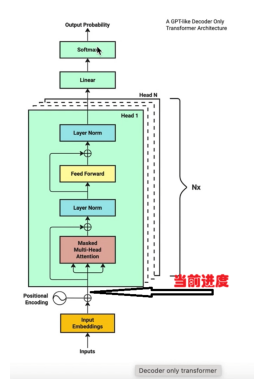

In [75]:
img5_path= '../../../z_using_files/img/article/decoder3.png'
img5 = mpimg.imread(img5_path)
plt.imshow(img5)
plt.axis('off')
plt.show()

# 4.多头注意力机制
在Transformer模型中，注意力机制(Attention)扮演着最重要的角色。其核心：

已经嵌入向量（Embedding）完成的句子 通过自注意力机制计算每个单词与其他单词的相似度

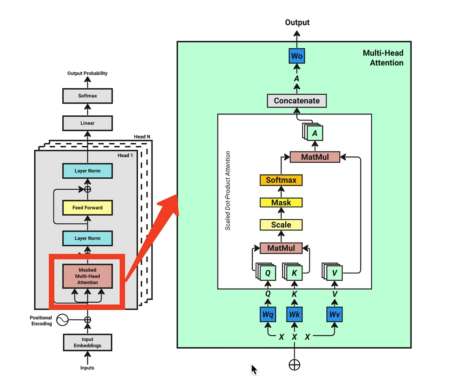

In [76]:
# 图片放大
img6_path= '../../../z_using_files/img/article/attention_6.png'
img6 = mpimg.imread(img6_path)
plt.imshow(img6)
plt.axis('off')
plt.show()

In [77]:
#  获取 Q,K,V
Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)
# Wq(x_batch)，PyTorch 会对 x_batch 的最后一个维度（即 d_model）进行线性变换
Q, K, V = Wq(x_batch), Wk(x_batch), Wv(x_batch)
logger.info(colored(f"{Q.shape},{K.shape},{V.shape}", "green"))

2025-01-12 10:05:49-INFO: torch.Size([4, 16, 64]),torch.Size([4, 16, 64]),torch.Size([4, 16, 64])


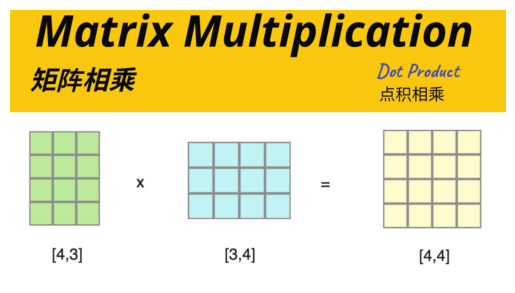

In [78]:
# 矩阵乘法复习
img9_path= '../../../z_using_files/img/article/dot_product.png'
img9 = mpimg.imread(img9_path)
plt.imshow(img9)
plt.axis('off')
plt.show()

In [79]:
# 多头变换
# view 将形状从 (batch_size, context_length, d_model) 转换为 (batch_size, context_length, num_heads, d_model // num_heads)
# permute 将维度重新排列为 (batch_size, num_heads, context_length, d_model // num_heads)
Q = Q.view(batch_size, context_length, num_heads, d_model // num_heads).permute(0, 2, 1, 3)
K = K.view(batch_size, context_length, num_heads, d_model // num_heads).permute(0, 2, 1, 3)
V = V.view(batch_size, context_length, num_heads, d_model // num_heads).permute(0, 2, 1, 3)
logger.info(colored(f"{Q.shape},{K.shape},{V.shape}", "green"))

2025-01-12 10:05:49-INFO: torch.Size([4, 4, 16, 16]),torch.Size([4, 4, 16, 16]),torch.Size([4, 4, 16, 16])


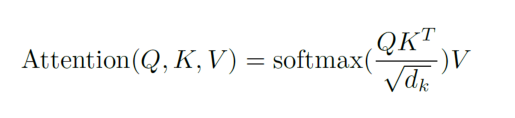

In [80]:
# 注意力公式
img10_path= '../../../z_using_files/img/article/attention_4.png'
img10 = mpimg.imread(img10_path)
plt.imshow(img10)
plt.axis('off')
plt.show()

In [81]:

# 注意力计算
output = Q @ K.transpose(-2, -1)
Dk = d_model // num_heads
output = output / math.sqrt(Dk)  # 缩放注意力分数，防止梯度爆炸

"""
训练过程添加 mask 为了确保模型在生成序列时只能访问当前时刻及之前的信息，而不能访问未来的信息
torch.ones(context_length, context_length): 创建一个大小为 (context_length, context_length) 的全 1 矩阵
torch.triu(): 返回上三角矩阵 diagonal=1 表示对角线以上的元素保留为 1 对角线及以下的元素置为 0 
.bool(): 将矩阵转换为布尔类型，方便后续的掩码操作
output.masked_fill(mask, float('-inf')): 将 mask 中为 1 的位置（即未来的信息）置为负无穷
这样在后续的 softmax 操作中，这些位置的概率会被压到 0 确保模型不会关注未来的信息。
"""
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1).bool()
output = output.masked_fill(mask, float('-inf'))

attention_output = F.softmax(output, dim=-1)
A = attention_output @ V
logger.info(colored(f"A-shape:{A.shape}", "green"))
pd.DataFrame(output[0, 0].cpu().detach().numpy())

2025-01-12 10:05:50-INFO: A-shape:torch.Size([4, 4, 16, 16])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.576407,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,-0.290984,-0.103939,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,-0.013882,-0.184875,-0.218325,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,-0.032749,0.567427,0.247793,0.514914,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,0.173969,0.016626,0.222331,0.070936,0.092847,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,-0.108443,0.094147,-0.250549,-0.285491,-0.378007,-0.416564,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,-0.041738,-0.090518,-0.066979,-0.158616,0.209397,0.569961,0.284061,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.487728,0.363265,0.579746,0.597638,0.247227,0.925408,0.293223,0.393889,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,-0.645815,-0.236327,-0.985271,-0.687769,-0.842902,-0.272680,-0.435218,-1.085718,-0.053313,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.017768,0.629956,-0.112518,-0.003282,0.046360,-0.542496,-0.426533,0.105825,-0.546869,-1.021624,-inf,-inf,-inf,-inf,-inf,-inf


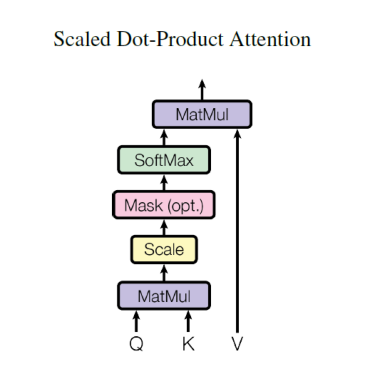

In [82]:
# 图片放大到当前进度位置
img8_path= '../../../z_using_files/img/article/attention_1.png'
img8 = mpimg.imread(img8_path)
plt.imshow(img8)
plt.axis('off')
plt.show()

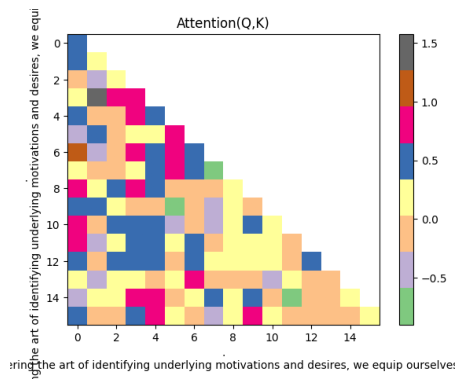

In [83]:
# Mask
img11_path= '../../../z_using_files/img/article/mask.png'
img11 = mpimg.imread(img11_path)
plt.imshow(img11)
plt.axis('off')
plt.show()

```python
Q @ K.transpose(-2, -1)
Wq(x_batch)
```
**这2种有什么区别?**

```text
@ 符号和 Wq(x_batch) 的使用场景不同，它们分别代表了 矩阵乘法 和 线性变换

1.如果 A 的形状是 (m, n)，B 的形状是 (n, p)，那么 A @ B 的结果形状是 (m, p)
Q 的形状是 (batch_size, num_heads, context_length, d_model // num_heads)
K.transpose(-2, -1) 为 (batch_size, num_heads, d_model // num_heads, context_length)
那么结果为:(batch_size, num_heads, context_length, context_length)

2.Wq(x_batch) 是一个 线性变换，它的作用是将输入 x_batch 从 d_model 维映射到 d_model 维
Wq 是一个线性层（nn.Linear），它包含一个权重矩阵 Wq.weight 和一个偏置向量 Wq.bias。
当调用 Wq(x_batch) 时，PyTorch 实际上执行的是以下矩阵乘法：
```
$ Q = x_{\text{batch}} \times W_q^T + b_q $

可以将 `Wq(x_batch)` 和 `Q @ K.transpose(-2, -1)` 类比为不同的数学运算：
- `Wq(x_batch)` 类似于 **函数变换**，例如 $ f(x) = Wx + b $，它将输入  x  映射到新的空间。
- `Q @ K.transpose(-2, -1)` 类似于 **内积计算**，例如 $ \langle q, k \rangle $，它计算两个向量之间的相似度。

In [84]:
# 合并多头
# contiguous 是 PyTorch 中的一个函数，用于确保张量的内存布局是连续的
# 调用 contiguous 会返回一个内存布局连续的新张量，确保后续的 view 操作可以正常执行。
# A.permute(0, 2, 1, 3): 将维度重新排列为 (batch_size, context_length, num_heads, d_model // num_heads)
# .view(batch_size, context_length, d_model): (b, context_length, num_heads, head_dim) ==> (b, context_length, d_model)
A = A.permute(0, 2, 1, 3).contiguous().view(batch_size, context_length, d_model)
A.shape

torch.Size([4, 16, 64])

In [85]:
# 线性变换
Wo = nn.Linear(d_model, d_model)
output = Wo(A)
output.shape

torch.Size([4, 16, 64])

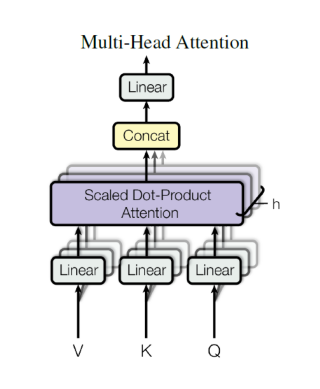

In [86]:
# 图片放大到当前进度位置
img7_path= '../../../z_using_files/img/article/attention_2.png'
img7 = mpimg.imread(img7_path)
plt.imshow(img7)
plt.axis('off')
plt.show()

In [87]:
# 残差链接
output = output + x_batch
# LayerNorm--层归一化
layer_norm1 = nn.LayerNorm(d_model)
layer_norm_output = layer_norm1(output)
# FFN
ffn = nn.Sequential(
    nn.Linear(d_model, d_model * 4),
    nn.ReLU(),
    nn.Linear(d_model * 4, d_model)
)
output = ffn(layer_norm_output)
# 残差链接
output = output + layer_norm_output
# LayerNorm 再一次
layer_norm2 = nn.LayerNorm(d_model)
output = layer_norm2(output)
output.shape

torch.Size([4, 16, 64])

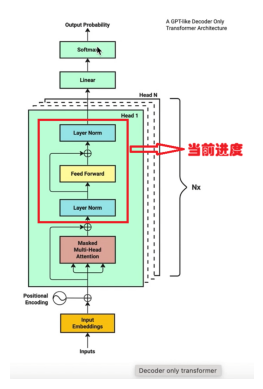

In [88]:
# 图片放大到当前进度位置
img11_path= '../../../z_using_files/img/article/decoder4.png'
img11 = mpimg.imread(img11_path)
plt.imshow(img11)
plt.axis('off')
plt.show()

In [89]:
# 线性变换 输出:nn.Linear(in_features, out_features)
output = nn.Linear(d_model, max_token_value + 1)(output)
output.shape

torch.Size([4, 16, 100253])

In [94]:
# softmax
logits = F.softmax(output, dim=-1)
logger.info(colored(f"{logits.shape}", "green"))
logits

2025-01-12 10:10:59-INFO: torch.Size([4, 16, 100253])


tensor([[[4.9429e-06, 6.4247e-06, 5.1736e-06,  ..., 1.5315e-05,
          5.0074e-06, 4.7786e-06],
         [1.3975e-05, 4.1631e-06, 1.8897e-05,  ..., 2.8847e-06,
          3.7162e-05, 6.0095e-06],
         [1.0986e-05, 5.3021e-06, 1.2545e-05,  ..., 3.7715e-06,
          1.4309e-05, 1.0823e-05],
         ...,
         [8.0294e-06, 6.9491e-06, 2.7636e-06,  ..., 4.9744e-06,
          8.3683e-06, 1.0527e-05],
         [9.0324e-06, 2.6575e-06, 1.0640e-05,  ..., 7.8270e-06,
          1.4526e-05, 5.6287e-06],
         [4.4986e-06, 6.8114e-06, 1.3809e-05,  ..., 4.9640e-06,
          2.2750e-05, 1.2221e-05]],

        [[2.1848e-05, 1.6665e-05, 4.3134e-06,  ..., 6.4184e-06,
          8.3689e-06, 8.4095e-06],
         [8.4998e-06, 6.9575e-06, 7.2525e-06,  ..., 4.6253e-06,
          1.1352e-05, 3.9157e-06],
         [9.6607e-06, 4.0110e-06, 9.7714e-06,  ..., 3.7678e-06,
          3.4153e-06, 5.6532e-06],
         ...,
         [1.8478e-06, 2.3645e-06, 4.2440e-06,  ..., 1.1183e-05,
          5.482

In [99]:
# 查看预测的文字
predict_index = torch.argmax(logits[0,0]).item()
predict_words = cl100k_base.decode([predict_index])
logger.info(colored(f"{predict_index},{predict_words}", "green"))

2025-01-12 10:14:58-INFO: 15118, Parse
